# Database Analysis Code

Contains code to analyse the training set dataset used for the MPScore. This includes: identifying the functional groups present in the training database; an analysis of the consistency between chemists and the correlation between the SAScore, SCScore and chemist data.

In [64]:
from sqlalchemy import create_engine
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import json
from collections import defaultdict
from rdkit.Chem import AllChem as rdkit
import csv
from rdkit.Chem.MolStandardize import standardize_smiles
import seaborn as sns
from rdkit import Chem
from matplotlib import pyplot as plt
import itertools as it
from pymongo import MongoClient
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min

In [ ]:
# Analysing the functional groups in the training dataset
def find_functional_groups():
    training_db = "data/training_mols.json"
    with open(training_db, "r") as f:
        training_db = json.load(f)
    fg_smarts = {
        'amine': ('[N]([H])[H]'),
        'aldehyde': ('[C](=[O])[H]'),
        'carboxylic_acid': ('[C](=[O])-[O][H]'),
        'fluorine': ('[F]'),
        'chlorine': ('[Cl]'),
        'bromine': ('[Br]'),
        'iodine': ('[I]'),
        'astatine': ('[As]'),
        'alcohol': ('[C]([H])([H])-[O][H]'),
        'alcohol2': ('[O][H]'),
        'alkene': ('[C]=[C]([H])[H]'),
        'alkyne': ('[C]#[C][H]'),
        'thiol': ('[S][H]'),
        'amide': ('[C](=[O])[N]([H])[H]'),
        'boronic_acid': ('[B]([O][H])[O][H]'),
        'xenon': ('[Xe]'),
        'methyl': ('[C]([H])([H])[H]'),
        'ethyl': ('[C]([H])([H])[C]([H])([H])[H]'),
        'propyl': ('[C]([H])([H])[C]([H])([H])[C]([H])([H])[H]'),
    }
    fg_counter = defaultdict(int)
    removed = []
    for inchi in tqdm(training_db):
        mol = Chem.AddHs(Chem.MolFromInchi(inchi))
        for fg in fg_smarts:
            fg_smart = fg_smarts[fg]
            counter = 0
            substruct = Chem.MolFromSmarts(fg_smart)
            matches = mol.GetSubstructMatches(substruct)
            counter += len(matches)
            # Ignore molecules if functional groups are less than two.
            if counter >= 2:
                fg_counter[f'{fg}_{counter}'] += 1
                removed.append(inchi)
                break
    sorted_db_funcs = sorted(fg_counter.items(), key=lambda x: x[0])
    db_funcs = pd.DataFrame(sorted_db_funcs)
    return db_funcs
db_fgs = find_functional_groups()

In [6]:
# Analysing chemist scores
def load_chemist_data():
    main_dir = Path('..').resolve()
    p1 = main_dir.joinpath("data/chemist_data/opinions_becky.json")
    p2 = main_dir.joinpath("data/chemist_data/opinions_mebriggs.json")
    p3 = main_dir.joinpath("data/chemist_data/filip.csv")
    # Finding disagreements in training data
    with open(str(p1)) as f:
        rg = json.load(f)
    with open(str(p2)) as f:
        mb = json.load(f)
    with open(str(p3)) as f:
        reader = csv.reader(f, delimiter='\t')
        fs = {rdkit.MolToInchi(rdkit.MolFromSmiles(smi)): sco for sco, smi in reader}
    def parse_training(training_dict):
        d = defaultdict(list)
        for inchi in training_dict:
            # Convert and standardise SMILES string.
            d['smiles'].append(standardize_smiles(rdkit.MolToSmiles(rdkit.MolFromInchi(inchi))))
            d['chemist_score'].append(int(training_dict[inchi]))
        return pd.DataFrame(d)
    fs = parse_training(fs)
    rg = parse_training(rg)
    mb = parse_training(mb)
    # Molecules scored by all three chemists
    all_three = rg.rename(columns={'chemist_score': 'RLG'}).merge(fs.rename(columns={'chemist_score': 'FS'}), on='smiles').merge(mb.rename(columns={'chemist_score': 'MB'}), on='smiles')
    # Molecules scored by two chemists
    two = pd.concat([rg.merge(fs, on='smiles'), fs.merge(mb, on='smiles'), rg.merge(mb, on='smiles')])
    mols = [] 
    rows = []
    count = 0
    for i, r in all_three.iterrows():
        if (int(r.RLG) != int(r.FS)) or (int(r.FS) != int(r.MB)):
            count+=1
            rows.append(r)
            mols.append(r.smiles)
    print(f"There were {len(all_three)} molecules labelled by all three chemists")
    print(f"{count} molecules were labelled the same by all three chemists and {len(all_three)-count} were labelled differently.")
    count = 0
    column_names = ['RLG', 'FS', 'MB']
    df1 = rg.merge(fs, on='smiles')
    df1[~df1['smiles'].isin(all_three['smiles'])]
    df2 = rg.merge(mb, on='smiles')
    df2[~df2['smiles'].isin(all_three['smiles'])]
    df3 = fs.merge(mb, on='smiles')
    df3[~df3['smiles'].isin(all_three['smiles'])]
    for r in pd.concat([df1, df2, df3]).itertuples():
        if (int(r.chemist_score_x) == int(r.chemist_score_y)):
            count+=1
    print(f'There were {count} molecules labelled the same out of those scored by two chemists.')
    print(f'There were {len(pd.concat([df1, df2, df3])) - count} molecules labelled differently out of those scored by two chemists.')
    print(f'RLG labelled {sum(rg.chemist_score)} easy-to-synthesise and {len(rg)-sum(rg.chemist_score)} difficult-to-synthesise')
    print(f'FS labelled {sum(fs.chemist_score)} easy-to-synthesise and {len(fs)-sum(fs.chemist_score)} difficult-to-synthesise')
    print(f'MB labelled {sum(mb.chemist_score)} easy-to-synthesise and {len(mb)-sum(mb.chemist_score)} difficult-to-synthesise')
    chemist_data = pd.concat([fs, mb, rg])
    return chemist_data
chemist_data = load_chemist_data()

RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] WARNING: Omitted undefined stereo
RDKit WARNING: [23:05:39] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [23:05:39]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [23:05:39] WARNI

There were 42 molecules labelled by all three chemists
11 molecules were labelled the same by all three chemists and 31 were labelled differently.
There were 1179 molecules labelled the same out of those scored by two chemists.
There were 446 molecules labelled differently out of those scored by two chemists.
RLG labelled 1109 easy-to-synthesise and 8891 difficult-to-synthesise
FS labelled 667 easy-to-synthesise and 1191 difficult-to-synthesise
MB labelled 232 easy-to-synthesise and 463 difficult-to-synthesise


In [ ]:
# Correlation between the SAScore and SCScore
def plot_figure4():
    df_training = pd.read_csv(main_dir.joinpath('data/chemist_data/training_data_with_sascores.csv'), names=['smiles', 'sas', 'scs', 'chemist_score', 'sas_norm', 'scs_norm'])
    # Scaling scores between 0 and 1
    df_training['sas_norm'] = [(val-10)/(1-10) for val in df_training['sas'].to_list()]
    df_training['scs_norm'] = [(val-5)/(1-5) for val in df_training['scs'].to_list()]
    # Plotting SA-SCScore correlations.
    print(f"The correlation between the SAScore and SCScore is: {df_training['scs'].corr(df_training['sas'])}")
    sns.set_style('white')
    palette = sns.color_palette() 
    # Green = palette[2] = Easy-to-synthesise
    # Red = palette[3] = Difficult-to-synthesise 
    colors = [palette[3]] + [palette[2]]
    g = sns.jointplot(
        data=df_training,
        x='sas_norm',
        y='scs_norm',
        hue='chemist_score',
        palette=colors,
        space=0.3,
        xlim=[0,1.1],
        ylim=[0,1.1],
        s=5,
        linewidth=0.2,
        height= 3.3
    )
    g.set_axis_labels(xlabel='SAScore', ylabel='SCScore', fontsize='medium')
    g.ax_joint.legend_.remove()
    g.ax_joint.tick_params('both', labelsize='medium')
    return g
plot_figure4()

## Hyperparameter Optimisation

In this section, we identifty the best parameters for the random forest model using a grid search hyperparameter tuning process. 
The code that runs this tuning process can be found in this [file](../scripts/hyperparam_opt.py) and the screened parameters are in this `JSON` [file](../scripts/hyperparameters/test_params.json).
The results of the parameter screening are also provided in a JSON format [here]()

In [219]:
def get_best_parameters(n_params=5, db_path=None):
    if db_path:
        data = pd.read_json(db_path)
    else:
        client = MongoClient("129.31.65.124")
        collection = client["sa_project"]["hyperparameters"]
        data = pd.DataFrame(list(collection.find()))
    best_n = data.query("run_id == '13105140745211489222'").sort_values(by='FBeta (Beta = 2/10)', ascending=False).iloc[0:5]
    return best_n
best_params = get_best_parameters()

In [220]:
best_params

,_id,Accuracy,Precision (Difficult-to-synthesise),Recall (Difficult-to-synthesise),Recall (Easy-to-synthesise),Precision (Easy-to-synthesise),F1,FBeta (Beta = 4/10),FBeta (Beta = 3/10),FBeta (Beta = 2/10),...,run_id,n_estimators,max_depth,min_samples_split,max_leaf_nodes,max_features,max_samples,fp_bit_length,fp_radius,min_samples_leaf
67991,609ef3af8a5f5402a9b2e85d,0.8812233979256213,0.8838645136411418,0.988532688429028,0.31813149820389536,0.8395733822125122,0.4607617701522585,0.6837407019386976,0.7386730734717667,0.7892965926530525,...,13105140745211489222,80,80.0,2,NaN,log2,0.1,1024,4,1.0
63006,609eb88436c80293a0296ccf,0.8813823796807989,0.8860166508548477,0.9856990204633733,0.3343606229432724,0.8194956153987037,0.4727680064034191,0.6794487282866125,0.7290915965023113,0.7745500546486866,...,13105140745211489222,50,80.0,2,NaN,log2,0.1,2046,3,1.0
61507,609ea95cfa7df1f67a6d021b,0.8791517482439815,0.8831404108241291,0.986729178797051,0.3148077800713445,0.8184689402509837,0.45432073997651673,0.6698985549250753,0.7224795674204758,0.7707370902405053,...,13105140745211489222,50,40.0,2,NaN,log2,0.1,512,4,1.0
63914,609ec16591a77100eba4b6f7,0.8832946668126379,0.8893204654862394,0.9835031255544673,0.35746183603890314,0.8039304776551137,0.49435201604511336,0.6851092320000012,0.7282538094446931,0.766784345105143,...,13105140745211489222,80,NaN,5,NaN,log2,0.1,512,4,1.0
63020,609eb8a15292006da373dc19,0.8832148268733112,0.8893122843669159,0.9834130011471078,0.3576153265425871,0.8034202144499701,0.49436082281955906,0.6848155802576095,0.7278824978877372,0.766342476389846,...,13105140745211489222,50,80.0,2,NaN,log2,0.1,4096,3,1.0


best_paramslected Molecules for Retrosynthetic Analysis


# POC Precursor Screening

In this section, we filter for easy-to-synthesise molecules using our developed MPScore, the SAScore and SCScore.
We show the distriubtions of synthetic difficulty scores for each precursor combination in our precursor database.

In [ ]:
def plot_figure6():
    # Loading Reaxys data
    import sys
    sys.path.append(str(main_dir))
    from scripts.mpscore import MPScore
    con = create_engine(
        f"sqlite:///{str(main_dir.joinpath('data/reaxys_precursors.db'))}"
    )
    df_reaxys = pd.read_sql(sql="synthetic_accesibility", con=con)
    # Perform standardization on all molecules in Reaxys.
    model = MPScore()
    model.restore()
    df_reaxys['standardized_smiles'] = [standardize_smiles(smi) for smi in df_reaxys['smiles']]
    df_reaxys['rfmodel_fulldataset'] = [model.predict_proba(rdkit.AddHs(rdkit.MolFromSmiles(x))) for x in tqdm(df_reaxys['standardized_smiles'])]
    bb_gen = it.product(
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "primary amine"].iterrows()),
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "aldehyde"].iterrows()),
    )
    combinations = defaultdict(list)
    smiles_cache = {}
    for bbs in tqdm(bb_gen):
        _bb = smiles_cache.get(bbs[0]['smiles'], None)
        amine_smiles =  _bb if _bb else standardize_smiles(bbs[0]['smiles'])
        _bb = amine_smiles
        smiles_cache[bbs[0]['smiles']] = _bb
        _bb = smiles_cache.get(bbs[1]['smiles'], None)
        aldehyde_smiles =  _bb if _bb else standardize_smiles(bbs[1]['smiles'])
        _bb = aldehyde_smiles
        smiles_cache[bbs[1]['smiles']] = _bb
        combinations["bb"].append(
            aldehyde_smiles + ',' + amine_smiles
        )
        combinations["sascore_combination"].append(sum(r["sascore"] for r in bbs)/2)
        combinations["scscore_combination"].append(sum(r["scscore"] for r in bbs)/2)
        combinations["rfmodel_fulldataset_combination"].append(sum(r["rfmodel_fulldataset"] for r in bbs)/2)
    df_combinations = pd.DataFrame(combinations)
    sns.set_style('white')
    palette = sns.color_palette()
    fig, ax = plt.subplots(1, figsize=(6.43420506434205/2, 3.1))
    sns.kdeplot(data=df_combinations, x='sascore_combination', ax=ax, color=palette[0])
    sns.kdeplot(data=df_combinations, x='scscore_combination', ax=ax, color=palette[1])
    sns.kdeplot(data=df_combinations, x='rfmodel_fulldataset_combination', ax=ax, color=palette[3])
    sns.despine()
    ax.set_xlabel('Synthetic Difficulty', fontsize='medium')
    ax.set_ylabel('Density', fontsize='medium')
    ax.axvline(df_combinations['sascore_combination'].quantile(0.01), 0, 0.7, color=palette[0], linestyle ="--")
    ax.text(df_combinations['sascore_combination'].quantile(0.01)+0.033, 3.7, f"{round(df_combinations['sascore_combination'].quantile(0.01), 2)}", color=palette[0], fontsize=8)
    ax.text(df_combinations['sascore_combination'].quantile(0.01)+0.03, 4, "SAScore", color=palette[0], fontsize=8)

    # ax.arrow(df_combinations['sascore_combination'].quantile(0.01), 4.45, -df_combinations['sascore_combination'].quantile(0.01), 0, color=palette[0], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.axvline(df_combinations['scscore_combination'].quantile(0.01), 0, 0.7, color=palette[1], linestyle ="--")
    ax.text(df_combinations['scscore_combination'].quantile(0.01)-0.05, 3.7, f"{round(df_combinations['scscore_combination'].quantile(0.01), 2)}", color=palette[1], fontsize=8)
    ax.text(df_combinations['scscore_combination'].quantile(0.01)-0.07, 4, "SCScore", color=palette[1], fontsize=8)

    # ax.arrow(1, 4.75, -df_combinations['scscore_combination'].quantile(0.01), 0, color=palette[1], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.axvline(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 0, 0.7, color=palette[3], linestyle ="--")
    ax.text(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)-0.05, 3.7, f"{round(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 2)}", color=palette[3], fontsize=8)
    ax.text(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)-0.11, 4, "MPScore", color=palette[3], fontsize=8)
    ax.tick_params(labelsize='medium')
    # ax.arrow(df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 4.15, -df_combinations['rfmodel_fulldataset_combination'].quantile(0.01), 0, color=palette[3], shape='full', head_width=0.25, head_length=0.03, length_includes_head=True)
    ax.set_xlim(0, 1.0)
    return fig, ax
df_combinations = plot_figure6()

In [ ]:
def get_precursor_combinations():
    # Loading Reaxys data
    import sys
    sys.path.append(str(main_dir))
    from scripts.mpscore import MPScore
    con = create_engine(
        f"sqlite:///{str(main_dir.joinpath('data/reaxys_precursors.db'))}"
    )
    df_reaxys = pd.read_sql(sql="synthetic_accesibility", con=con)
    # Perform standardization on all molecules in Reaxys.
    model = MPScore()
    model.restore('models/mpscore.joblib')
    df_reaxys['standardized_smiles'] = [standardize_smiles(smi) for smi in df_reaxys['smiles']]
    df_reaxys['rfmodel_fulldataset'] = [model.predict_proba(rdkit.AddHs(rdkit.MolFromSmiles(x))) for x in tqdm(df_reaxys['standardized_smiles'])]
    bb_gen = it.product(
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "primary amine"].iterrows()),
        (r[1] for r in df_reaxys[df_reaxys["func_group"] == "aldehyde"].iterrows()),
    )
    combinations = defaultdict(list)
    smiles_cache = {}
    for bbs in tqdm(bb_gen):
        _bb = smiles_cache.get(bbs[0]['smiles'], None)
        amine_smiles =  _bb if _bb else standardize_smiles(bbs[0]['smiles'])
        _bb = amine_smiles
        smiles_cache[bbs[0]['smiles']] = _bb
        _bb = smiles_cache.get(bbs[1]['smiles'], None)
        aldehyde_smiles =  _bb if _bb else standardize_smiles(bbs[1]['smiles'])
        _bb = aldehyde_smiles
        smiles_cache[bbs[1]['smiles']] = _bb
        combinations["bb"].append(
            aldehyde_smiles + ',' + amine_smiles
        )
        combinations["sascore_combination"].append(sum(r["sascore"] for r in bbs)/2)
        combinations["scscore_combination"].append(sum(r["scscore"] for r in bbs)/2)
        combinations["rfmodel_fulldataset_combination"].append(sum(r["rfmodel_fulldataset"] for r in bbs)/2)
    return pd.DataFrame(combinations)
df_combinations = get_precursor_combinations()

In [ ]:
def plot_figure_7():
    # Loading optimised cages
    df = pd.read_json('cages.json').drop_duplicates('bb')
    df_random_selection = pd.read_json('control_cages.json')
    df_random_selection = df_random_selection.rename(columns={'_id':'bb'})
    # Selecting first percentile of synthetic accessibility scores for the MPScore.
    ecm_selected_full = df_combinations[df_combinations['rfmodel_fulldataset_combination'] < df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)].drop_duplicates('bb')
    sa_selected = df_combinations[df_combinations['sascore_combination'] < df_combinations['sascore_combination'].quantile(0.01)].drop_duplicates('bb')
    sc_selected = df_combinations[df_combinations['scscore_combination'] < df_combinations['scscore_combination'].quantile(0.01)].drop_duplicates('bb')
    ecm_cages = ecm_selected_full[ecm_selected_full['bb'].isin(df['bb'])]
    ecm_cages = pd.merge(ecm_cages, df, left_on='bb', right_on='bb')
    sa_cages = sa_selected[sa_selected['bb'].isin(df['bb'])]
    sa_cages = pd.merge(sa_cages, df, left_on='bb', right_on='bb')
    sc_cages = sc_selected[sc_selected['bb'].isin(df['bb'])]
    sc_cages = pd.merge(sc_cages, df, left_on='bb', right_on='bb')
    sp_sc_cages = sc_cages[(sc_cages['collapsed'] == False) & (sc_cages['cavity_size'] > 1.0)].drop_duplicates('bb')
    sp_ecm_cages = ecm_cages[(ecm_cages['collapsed'] == False) & (ecm_cages['cavity_size'] > 1.0)].drop_duplicates('bb')
    sp_sa_cages = sa_cages[(sa_cages['collapsed'] == False) & (sa_cages['cavity_size'] > 1.0)].drop_duplicates('bb')
    sp_random = df_random_selection[(df_random_selection['collapsed'] == False) &  (df_random_selection['cavity_size'] > 1.0)].drop_duplicates('bb')
    print(f"Mean of SCScore selected cages: {sp_sc_cages['cavity_size'].mean()}")
    print(f"Mean of SAScore selected cages: {sp_sa_cages['cavity_size'].mean()}")
    print(f"Mean of MPScore selected cages: {sp_ecm_cages['cavity_size'].mean()}")
    print(f"Mean of randomly selected cages: {sp_random['cavity_size'].mean()}")
    print(
        f"Number of shape persistent from SCScore: {len(sp_sc_cages)}\n"
        f"Number of shape persistent from SAScore: {len(sp_sa_cages)}\n"
        f"Number of shape persistent from MPScore: {len(sp_ecm_cages)}\n"
        f"Number of shape persistent from control sample: {len(sp_random)}\n"
    )
    palette = sns.color_palette()
    colors = {
        'sascore': palette[0],
        'scscore': palette[1],
        'ecm': palette[3]
    }
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(6.43420506434205/2, 3.3))
    ecm_cavity_sizes = sp_ecm_cages['cavity_size']
    sns.histplot(x=ecm_cavity_sizes, ax=ax, kde=False, color=colors['ecm'], element='step', edgecolor=colors['ecm'], linewidth=1, alpha=0.4, label='MPScore')
    sa_cavity_sizes =sp_sa_cages['cavity_size']
    sns.histplot(x=sa_cavity_sizes, ax=ax , kde=False, color=colors['sascore'], element='step', edgecolor=colors['sascore'], linewidth=1, alpha=0.4, label='SAScore')
    random_cavity_sizes = df_random_selection[(df_random_selection['collapsed'] == False) &  (df_random_selection['cavity_size'] > 1.0)]['cavity_size']
    sns.histplot(x=random_cavity_sizes, ax=ax, kde=False, color='green', element='step', edgecolor='green', linewidth=1, alpha=0.4, label='Control Sample')
    sc_cavity_sizes = sp_sc_cages['cavity_size']
    sns.histplot(x=sc_cavity_sizes, ax=ax, kde=False, color=colors['scscore'], element='step', edgecolor=colors['scscore'], linewidth=1, alpha=0.4, label='SCScore')
    ax.set_xlim(0, 25)
    ax.set_xlabel('Cavity Diameter / Å', fontsize='medium')
    ax.set_ylabel('Number of Cages', fontsize='medium')
    sns.despine()
    ax.tick_params(labelsize='medium')
    ax.legend()
    return fig
plot_figure_7()

In [ ]:
def get_largest_cages():
    df = pd.read_json('cages.json').drop_duplicates('bb')
    ecm_selected_full = df_combinations[df_combinations['rfmodel_fulldataset_combination'] < df_combinations['rfmodel_fulldataset_combination'].quantile(0.01)].drop_duplicates('bb')
    sa_selected = df_combinations[df_combinations['sascore_combination'] < df_combinations['sascore_combination'].quantile(0.01)].drop_duplicates('bb')
    sc_selected = df_combinations[df_combinations['scscore_combination'] < df_combinations['scscore_combination'].quantile(0.01)].drop_duplicates('bb')
    ecm_cages = ecm_selected_full[ecm_selected_full['bb'].isin(df['bb'])]
    ecm_cages = pd.merge(ecm_cages, df, left_on='bb', right_on='bb')
    sa_cages = sa_selected[sa_selected['bb'].isin(df['bb'])]
    sa_cages = pd.merge(sa_cages, df, left_on='bb', right_on='bb')
    sc_cages = sc_selected[sc_selected['bb'].isin(df['bb'])]
    sc_cages = pd.merge(sc_cages, df, left_on='bb', right_on='bb')
    sp_sc_cages = sc_cages[(sc_cages['collapsed'] == False) & (sc_cages['cavity_size'] > 1.0)]
    sp_ecm_cages = ecm_cages[(ecm_cages['collapsed'] == False) & (ecm_cages['cavity_size'] > 1.0)]
    sp_sa_cages = sa_cages[(sa_cages['collapsed'] == False) & (sa_cages['cavity_size'] > 1.0)]
    sp_random = df_random_selection[(df_random_selection['collapsed'] == False) &  (df_random_selection['cavity_size'] > 1.0)]
    largest_cages = pd.concat([sp_sc_cages, sp_sa_cages, sp_ecm_cages])
    largest_cages = largest_cages.query('cavity_size > 16.0')
    # Used to replace SMILES strings, one does not contain stereochemistry
    new_ids = largest_cages['bb'].apply(lambda x: x.replace('O=Cc1ccc(/C=C/c2cc(/C=C/c3ccc(C=O)cc3)cc(/C=C/c3ccc(C=O)cc3)c2)cc1', 'O=Cc1ccc(C=Cc2cc(C=Cc3ccc(C=O)cc3)cc(C=Cc3ccc(C=O)cc3)c2)cc1')).to_list()
    largest_cages['bb'] = new_ids
    largest_cages = largest_cages.drop_duplicates('bb')
    print(f"There are {len(largest_cages)} with cavity diameter of larger than 16 Å")
    return largest_cages
get_largest_cages()

# Identifying Molecules with Similar Features

In [160]:
def group_molecules(chemist_data):
    e2s = chemist_data.query('chemist_score == 1')
    d2s = chemist_data.query('chemist_score == 0')
    e2s_fps = [rdkit.GetMorganFingerprintAsBitVect(rdkit.MolFromSmiles(m), nBits=1024, radius=3) for m in e2s['smiles']]
    d2s_fps = [rdkit.GetMorganFingerprintAsBitVect(rdkit.MolFromSmiles(m), nBits=1024, radius=3) for m in d2s['smiles']]
    pca1 = PCA(n_components=50, random_state=32)
    e2s_components = pca1.fit_transform(e2s_fps)
    print(f"For easy-to-synthesise, PCA capture {np.sum(pca1.explained_variance_ratio_)*100}% of the variance")
    pca2 = PCA(n_components=50, random_state=32)
    d2s_components = pca2.fit_transform(d2s_fps)
    print(f"For difficult-to-synthesise, PCA capture {np.sum(pca2.explained_variance_ratio_)*100}% of the variance")
    
    def find_best_sil(X):
        sil = {}
        intertias = []
        for i in range(2, 11, 1):
            kmeans = KMeans(n_clusters=i, random_state=32)
            kmeans.fit(X)
            intertias.append(kmeans.inertia_)
            sil[i] = silhouette_score(X, kmeans.labels_)
            print(f"Intertia for {i} clusters is {kmeans.inertia_}. Silhouette score is {sil[i]}")


        max_sil = max(sil.items(), key=lambda x: x[1])
        best_cluster = max_sil[0]
        print(f"The best performing cluster is {best_cluster} with a score of {max_sil[1]}")
        return best_cluster
    
    def find_closest_cluster(clusters, X_transformed):
        kmeans = KMeans(n_clusters=clusters, random_state=32)
        kmeans.fit(X_transformed)
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_transformed)
        return closest
        

    e2s_nclusters = find_best_sil(e2s_components)
    d2s_nclusters = find_best_sil(d2s_components)
    e2s_closest_idx = find_closest_cluster(clusters=10, X_transformed=e2s_components)
    e2s_closest_mols = [rdkit.MolFromSmiles(m) for m in e2s['smiles'].iloc[e2s_closest_idx]]
    d2s_closest_idx = find_closest_cluster(clusters=10, X_transformed=d2s_components)
    d2s_closest_mols = [rdkit.MolFromSmiles(m) for m in d2s['smiles'].iloc[d2s_closest_idx]]
    return e2s_closest_mols, d2s_closest_mols


In [161]:
e2s_mols, d2s_mols = group_molecules(chemist_data)

For easy-to-synthesise, PCA capture 49.80771641537925% of the variance
For difficult-to-synthesise, PCA capture 36.69245588128366% of the variance
Intertia for 2 clusters is 18889.269459378993. Silhouette score is 0.04404620944981797
Intertia for 3 clusters is 17726.78599807233. Silhouette score is 0.06866733092896751
Intertia for 4 clusters is 16815.58618813486. Silhouette score is 0.08479694509426369
Intertia for 5 clusters is 16149.032935432528. Silhouette score is 0.09740232796392426
Intertia for 6 clusters is 15659.815844134753. Silhouette score is 0.10633641453312277
Intertia for 7 clusters is 15197.464646760754. Silhouette score is 0.06638839506375362
Intertia for 8 clusters is 14840.019742822955. Silhouette score is 0.07462295911074342
Intertia for 9 clusters is 14385.803414405173. Silhouette score is 0.08803967157641517
Intertia for 10 clusters is 14030.53408248692. Silhouette score is 0.09120588149790054
The best performing cluster is 6 with a score of 0.10633641453312277
Int

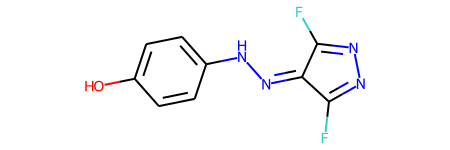

In [155]:
d2s_mols[9]